In [1]:
from environment import CoronagraphEnvironment
import hcipy
from hcipy import *
from matplotlib import pyplot as plt
import numpy as np

In [2]:
e = CoronagraphEnvironment(num_modes=10)

initializing coronagraph env. might take a minute.


1e-20


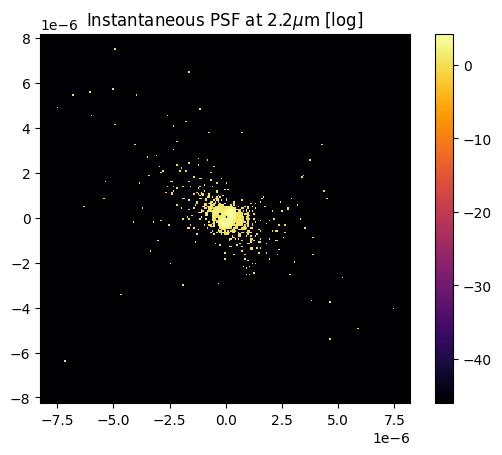

In [450]:
#e.set_random_dm(noise=0.01)
plt.title('Instantaneous PSF at 2.2$\\mu$m [log]')

clipped = (np.clip(e.get_camera_image(), a_min = 1e-20, a_max = None))

print(np.min(clipped))
imshow_field(np.log(clipped), cmap='inferno')
plt.colorbar()
plt.show()

In [4]:
print(e.get_slopes())

[[ 5.24461903e-06  1.93129771e-05  1.76391850e-05 ...  1.59882410e-05
  -2.75437122e-05 -1.62564425e-05]
 [ 1.70584960e-05  2.32976430e-05  2.16987077e-05 ... -1.10595099e-05
  -3.75317820e-06 -1.21474627e-05]]


In [6]:
from tqdm import tqdm

# Build out a training dataset for a traditional CNN encoder.

# Example: Generate a dataset of N random DM settings and their corresponding images
N = 5000  # Number of samples
images = []
dm_settings = []
slopes = []

for _ in tqdm(range(N), desc="Building dataset"):
    e.set_random_dm(noise=0.01)
    images.append(np.log(np.clip(e.get_camera_image(), a_min = 1e-8, a_max = None)))
    dm_settings.append(e.get_perfect_adjustment()) 
    slopes.append(e.get_slopes())

# Normalize dm_settings to zero mean and unit variance
dm_settings = np.array(dm_settings)
dm_mean = dm_settings.mean(axis=0)
dm_std = dm_settings.std(axis=0)
dm_settings_norm = (dm_settings - dm_mean) / (dm_std + 1e-8)

# Normalize slopes to zero mean and unit variance
slopes = np.array(slopes)
slopes_mean = slopes.mean(axis=0)
slopes_std = slopes.std(axis=0)
slopes_norm = (slopes - slopes_mean) / (slopes_std + 1e-8)

Building dataset: 100%|██████████| 5000/5000 [06:40<00:00, 12.50it/s]


In [7]:
import pickle

for_export = {
    "dm_settings": dm_settings,
    "dm_settings_norm": dm_settings_norm,
    "slopes": slopes,
    "slopes_norm": slopes_norm,
    "images": images
}

with open('data/noise01/5000_2.pkl', 'wb') as f:
    pickle.dump(for_export, f)

In [38]:
from sklearn.model_selection import train_test_split

# Convert images (list of OldStyleField) to numpy arrays for ML usage
X = np.array([np.array(img).reshape((240,240)) for img in images])
y = dm_settings_norm

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

np.float64(-18.420680743952367)

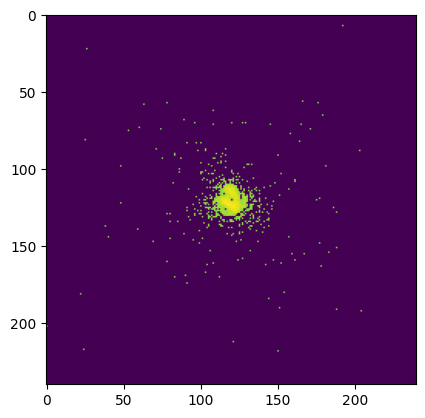

In [10]:
plt.imshow(X[2])
np.min(X[2])

In [50]:
256 * 15 * 15

57600

In [61]:
import torch

import torch.nn as nn
import torchvision.models as models

class LargeImageEncoderNet(nn.Module):
    def __init__(self, output_dim=500, input_shape=(224, 224)):
        super(LargeImageEncoderNet, self).__init__()
        h, w = input_shape
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear((h + 4) * (w + 4), 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim)
        )
        

    def forward(self, x):
        return self.encoder(x)
    
# Example usage:
# model = LargeImageEncoderNet(output_dim=500)
# output = model(torch.randn(1, 3, 224, 224))  # Example input

In [62]:
# Crop X_train to the middle 100x100 pixels
h, w = X_train.shape[1], X_train.shape[2]
start_h = (h - 60) // 2
start_w = (w - 60) // 2
X_train_cropped = X_train[:, start_h:start_h+60, start_w:start_w+60]


(4000, 60, 60)


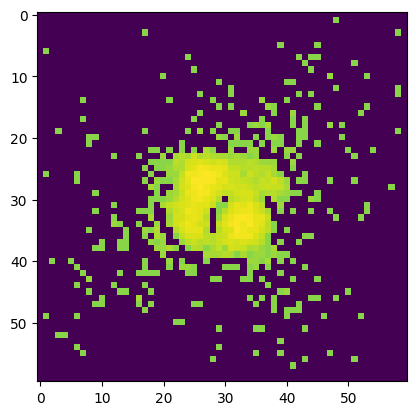

In [63]:
print(X_train_cropped.shape)
plt.imshow(X_train_cropped[0])

In [64]:
# Prepare data for training
import torch.optim as optim

# Add channel dimension for grayscale images (shape: [batch, channel, height, width])
X_train_tensor = torch.tensor(X_train_cropped, dtype=torch.float32).unsqueeze(1)  # shape: [4000, 1, w, h]

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Initialize model, loss, and optimizer
model = LargeImageEncoderNet(output_dim=y_train.shape[1], input_shape=X_train_tensor[0].shape[1:])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [65]:
X_train_tensor.shape

torch.Size([4000, 1, 60, 60])

In [66]:
np.sqrt(4096)

np.float64(64.0)

In [99]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64
epochs = 500
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    avg_loss = epoch_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


Epoch 1/500, Loss: 0.0108
Epoch 2/500, Loss: 0.0108
Epoch 3/500, Loss: 0.0107
Epoch 4/500, Loss: 0.0109
Epoch 5/500, Loss: 0.0109
Epoch 6/500, Loss: 0.0110
Epoch 7/500, Loss: 0.0110
Epoch 8/500, Loss: 0.0117
Epoch 9/500, Loss: 0.0120
Epoch 10/500, Loss: 0.0121
Epoch 11/500, Loss: 0.0111
Epoch 12/500, Loss: 0.0101
Epoch 13/500, Loss: 0.0092
Epoch 14/500, Loss: 0.0096
Epoch 15/500, Loss: 0.0103
Epoch 16/500, Loss: 0.0111
Epoch 17/500, Loss: 0.0123
Epoch 18/500, Loss: 0.0123
Epoch 19/500, Loss: 0.0107
Epoch 20/500, Loss: 0.0095
Epoch 21/500, Loss: 0.0087
Epoch 22/500, Loss: 0.0091
Epoch 23/500, Loss: 0.0097
Epoch 24/500, Loss: 0.0097
Epoch 25/500, Loss: 0.0092
Epoch 26/500, Loss: 0.0088
Epoch 27/500, Loss: 0.0088
Epoch 28/500, Loss: 0.0099
Epoch 29/500, Loss: 0.0099
Epoch 30/500, Loss: 0.0094
Epoch 31/500, Loss: 0.0094
Epoch 32/500, Loss: 0.0089
Epoch 33/500, Loss: 0.0086
Epoch 34/500, Loss: 0.0083
Epoch 35/500, Loss: 0.0078
Epoch 36/500, Loss: 0.0082
Epoch 37/500, Loss: 0.0084
Epoch 38/5

In [100]:
# Define the path to save the model
PATH = "models/CNN1 weights.pth"

# Save the model's state_dict
torch.save(model.state_dict(), PATH)

cuda


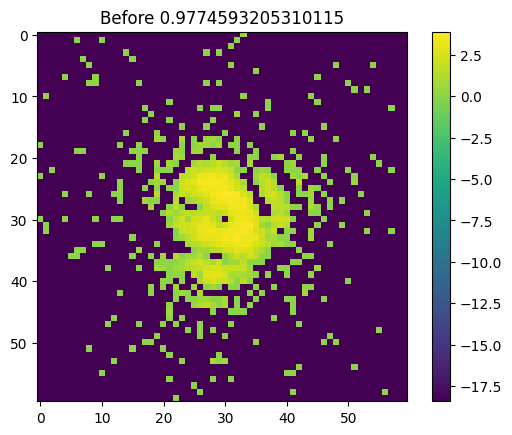

torch.Size([1, 1, 60, 60])


C:\Users\alexe\AppData\Local\Temp\ipykernel_45672\2041744883.py:36: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  e.set_dm(np.array(y_pred[0].to('cpu')) * dm_std + dm_mean)


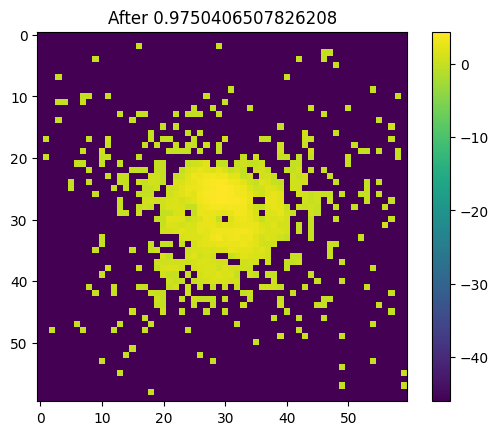

In [147]:
e.set_random_dm(noise=0.01)

plt.title(f'Before {e.get_strehl_ratio()}')
image = [np.log(np.clip(e.get_camera_image(), a_min = 1e-8, a_max = None))]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

image = np.array(image)

image_size = image.shape[-1]

image_reshaped = image.reshape(
    (int(np.sqrt(image_size))), int(np.sqrt(image_size))
)

h, w = image_reshaped.shape[0], image_reshaped.shape[1]
start_h = (h - 60) // 2
start_w = (w - 60) // 2
image_cropped = image_reshaped[start_h:start_h+60, start_w:start_w+60]

plt.imshow(image_cropped)
plt.colorbar()
plt.show()

image_tensor = torch.tensor(image_cropped, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
print(image_tensor.shape)


#manual_test_torch = torch.tensor(image.transpose(0, 3, 1, 2), dtype=torch.float32)
#manual_test_torch = F.interpolate(manual_test_torch, size=(224, 224), mode='bilinear', align_corners=False)
#manual_test_torch = manual_test_torch.to(device)
with torch.no_grad():
    y_pred = model(image_tensor)

e.set_dm(np.array(y_pred[0].to('cpu')) * dm_std + dm_mean)

plt.title(f'After {e.get_strehl_ratio()}')
image = [np.log(np.clip(e.get_camera_image(), a_min = 10 ** -20, a_max = None))]

image = np.array(image)

image_size = image.shape[-1]

image_reshaped = image.reshape(
    (int(np.sqrt(image_size))), int(np.sqrt(image_size))
)

h, w = image_reshaped.shape[0], image_reshaped.shape[1]
start_h = (h - 60) // 2
start_w = (w - 60) // 2
image_cropped = image_reshaped[start_h:start_h+60, start_w:start_w+60]

plt.imshow(image_cropped)
plt.colorbar()
plt.show()

C:\Users\alexe\AppData\Local\Temp\ipykernel_45672\133515688.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  e.set_dm(0.05 * (np.array(y_pred[0].to('cpu')) * dm_std + dm_mean))


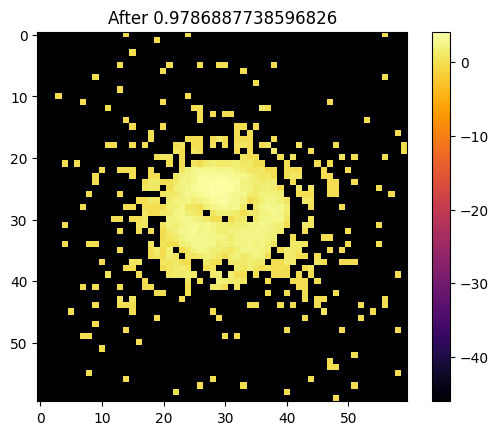

In [164]:
for _ in range(10):
    image = [np.log(np.clip(e.get_camera_image(), a_min = 1e-8, a_max = None))]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    image = np.array(image)

    image_size = image.shape[-1]

    image_reshaped = image.reshape(
        (int(np.sqrt(image_size))), int(np.sqrt(image_size))
    )

    h, w = image_reshaped.shape[0], image_reshaped.shape[1]
    start_h = (h - 60) // 2
    start_w = (w - 60) // 2
    image_cropped = image_reshaped[start_h:start_h+60, start_w:start_w+60]

    image_tensor = torch.tensor(image_cropped, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    #manual_test_torch = torch.tensor(image.transpose(0, 3, 1, 2), dtype=torch.float32)
    #manual_test_torch = F.interpolate(manual_test_torch, size=(224, 224), mode='bilinear', align_corners=False)
    #manual_test_torch = manual_test_torch.to(device)
    with torch.no_grad():
        y_pred = model(image_tensor)
    e.set_dm(0.05 * (np.array(y_pred[0].to('cpu')) * dm_std + dm_mean))

plt.title(f'After {e.get_strehl_ratio()}')
image = [np.log(np.clip(e.get_camera_image(), a_min = 10 ** -20, a_max = None))]

image = np.array(image)

image_size = image.shape[-1]

image_reshaped = image.reshape(
    (int(np.sqrt(image_size))), int(np.sqrt(image_size))
)

h, w = image_reshaped.shape[0], image_reshaped.shape[1]
start_h = (h - 60) // 2
start_w = (w - 60) // 2
image_cropped = image_reshaped[start_h:start_h+60, start_w:start_w+60]

plt.imshow(image_cropped, cmap='inferno')
plt.colorbar()
plt.show()

In [172]:
y_train_tensor.shape

torch.Size([4000, 10])

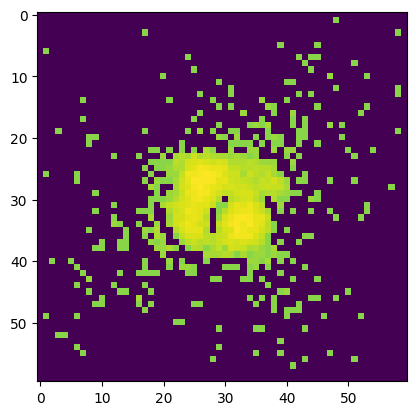

In [193]:
plt.imshow(X_train_tensor[0][0])


In [ ]:
# DO TRAINING 
# DO CHARTER
"Identified a cybersecurity risk exposed in Kenvue automation and AI"

y_pred: [-4.94019648e-09  2.96007115e-08  1.97601998e-08  2.46451401e-08
 -4.22775358e-09 -3.82127950e-08  3.52473913e-08  2.00435401e-09
 -1.10813715e-08  2.16169580e-08]
normal = [-9.78013422e-09  3.15294996e-08  1.56225570e-08  2.66921261e-08
 -7.16825244e-10 -4.54054857e-08  3.41027649e-08  1.61706350e-09
 -1.39797426e-08  2.42405511e-08]
after = [ 9.78013422e-09 -3.15294996e-08 -1.56225570e-08 -2.66921261e-08
  7.16825244e-10  4.54054857e-08 -3.41027649e-08 -1.61706350e-09
  1.39797426e-08 -2.42405511e-08]


C:\Users\alexe\AppData\Local\Temp\ipykernel_45672\1838549156.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  e.set_dm(np.array(-y_train_tensor[0]) * dm_std + dm_mean)
C:\Users\alexe\AppData\Local\Temp\ipykernel_45672\1838549156.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  print(f"y_pred: {np.array(y_pred[0].to('cpu')) * dm_std + dm_mean}")


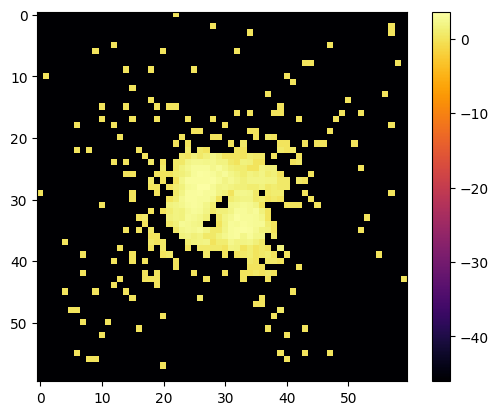

In [435]:
e.deformable_mirror.flatten()
e.set_dm(np.array(-y_train_tensor[0]) * dm_std + dm_mean)

with torch.no_grad():
    y_pred = model(X_train_tensor[0].unsqueeze(0))

print(f"y_pred: {np.array(y_pred[0].to('cpu')) * dm_std + dm_mean}")
print(f"normal = {-e.deformable_mirror.actuators}")

# e.set_dm(np.array(y_pred[0].to('cpu')) * dm_std + dm_mean )
print(f"after = {e.deformable_mirror.actuators}")

image = [np.log(np.clip(e.get_camera_image(), a_min = 10 ** -20, a_max = None))]

image = np.array(image)

image_size = image.shape[-1]

image_reshaped = image.reshape(
    (int(np.sqrt(image_size))), int(np.sqrt(image_size))
)

h, w = image_reshaped.shape[0], image_reshaped.shape[1]
start_h = (h - 60) // 2
start_w = (w - 60) // 2
image_cropped = image_reshaped[start_h:start_h+60, start_w:start_w+60]

plt.imshow(image_cropped, cmap='inferno')
plt.colorbar()
plt.show()

### Below is old code, not using new image cropping technique

In [98]:
from sklearn.model_selection import train_test_split

# Convert images (list of OldStyleField) to numpy arrays for ML usage
X = np.array([np.array(slope) for slope in slopes_norm])
y = dm_settings_norm

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

In [99]:
import torch

import torch.nn as nn
import torchvision.models as models

class LargeImageEncoderNet(nn.Module):
    def __init__(self, output_dim=500, input_shape=(3, 224, 224)):
        super(LargeImageEncoderNet, self).__init__()
        h, w = input_shape
        self.encoder = nn.Sequential(
            nn.Linear(h * w, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )
        

    def forward(self, x):
        return self.encoder(x)
    
    

# Example usage:
# model = LargeImageEncoderNet(output_dim=500)
# output = model(torch.randn(1, 3, 224, 224))  # Example input

In [ ]:
# Prepare data for training
import torch.optim as optim

# Flatten X_train if needed (currently shape: (800, 2, 1849))
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Initialize model, loss, and optimizer
model = LargeImageEncoderNet(output_dim=y_train.shape[1], input_shape=(2, 1849))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

RuntimeError: Given groups=1, weight of size [32, 1, 5, 5], expected input[1, 4000, 240, 240] to have 1 channels, but got 4000 channels instead

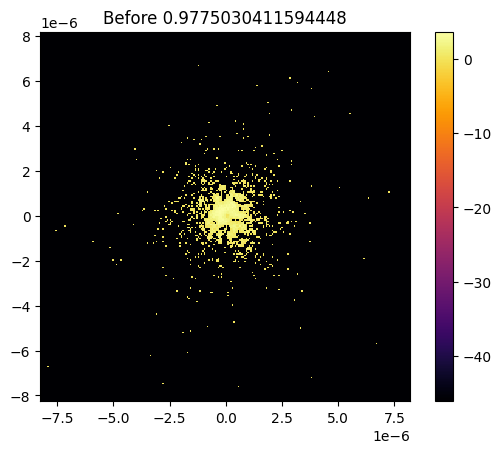

cuda


C:\Users\alexe\AppData\Local\Temp\ipykernel_36284\1351517651.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  e.set_dm(np.array(y_pred[0].to('cpu')) * dm_std + dm_mean)


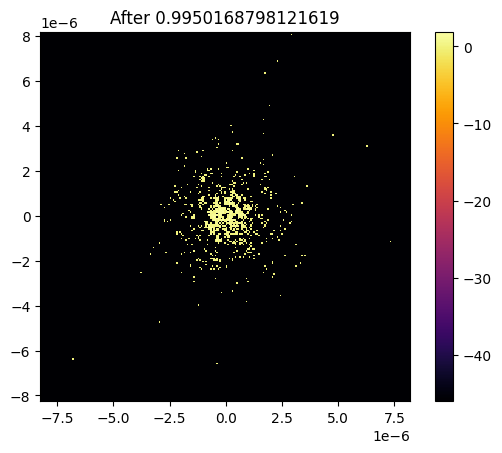

In [185]:
e.set_random_dm(noise=0.01)

plt.title(f'Before {e.get_strehl_ratio()}')
image = [np.log(np.clip(e.get_camera_image(), a_min = 10 ** -20, a_max = None))]

imshow_field(image[0], cmap='inferno')
plt.colorbar()
plt.show()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
test_slope_standard = torch.tensor((e.get_slopes() - slopes_mean) / slopes_std, dtype=torch.float32).to('cpu')
test_slope_standard = test_slope_standard.reshape(1, -1)


#manual_test_torch = torch.tensor(image.transpose(0, 3, 1, 2), dtype=torch.float32)
#manual_test_torch = F.interpolate(manual_test_torch, size=(224, 224), mode='bilinear', align_corners=False)
#manual_test_torch = manual_test_torch.to(device)
with torch.no_grad():
    y_pred = model(test_slope_standard)

e.set_dm(np.array(y_pred[0].to('cpu')) * dm_std + dm_mean)

plt.title(f'After {e.get_strehl_ratio()}')
image = [np.log(np.clip(e.get_camera_image(), a_min = 10 ** -20, a_max = None))]

imshow_field(image[0], cmap='inferno')
plt.colorbar()
plt.show()

In [313]:
e.set_random_dm(noise=0.01)
slopes = e.get_slopes()
print(np.min(slopes))
print(np.max(e.get_camera_image().shape))

-3.644932422316137e-05
57600


C:\Users\alexe\AppData\Local\Temp\ipykernel_36284\1540029973.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  e.set_dm(np.array(y_pred[0].to('cpu')) * dm_std + dm_mean)


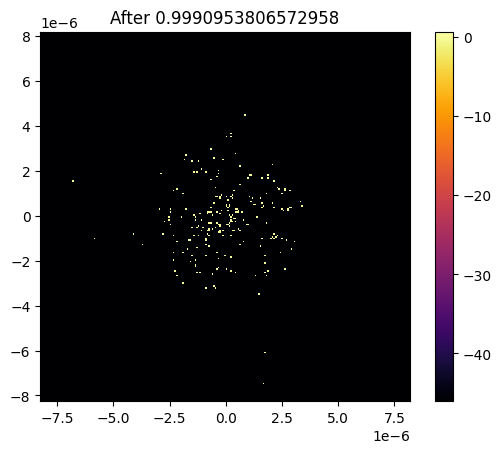

In [202]:
for _ in range(10):
    test_slope_standard = torch.tensor((e.get_slopes() - slopes_mean) / slopes_std, dtype=torch.float32).to('cpu')
    test_slope_standard = test_slope_standard.reshape(1, -1)


    #manual_test_torch = torch.tensor(image.transpose(0, 3, 1, 2), dtype=torch.float32)
    #manual_test_torch = F.interpolate(manual_test_torch, size=(224, 224), mode='bilinear', align_corners=False)
    #manual_test_torch = manual_test_torch.to(device)
    with torch.no_grad():
        y_pred = model(test_slope_standard)
    e.set_dm(np.array(y_pred[0].to('cpu')) * dm_std + dm_mean)

plt.title(f'After {e.get_strehl_ratio()}')
image = [np.log(np.clip(e.get_camera_image(), a_min = 10 ** -20, a_max = None))]

imshow_field(image[0], cmap='inferno')
plt.colorbar()
plt.show()